# imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
from os import listdir
from os.path import isfile, join
from tqdm import tqdm
import cv2
import pickle
import datetime
import time
import random
import collections

import tensorflow as tf
from tensorflow.keras import optimizers
from tensorflow.keras.preprocessing.image import ImageDataGenerator 
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, Conv2D, MaxPooling2D
from tensorflow.keras.callbacks import TensorBoard, LearningRateScheduler, ModelCheckpoint, CSVLogger, EarlyStopping
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import BatchNormalization
import multiprocessing as mp

# helper function to prepare test data

In [ ]:
def prepare_test_data():
    data_set = []
    test_dir = '/Users/flo/Desktop/456/_SEMESTER_PROJECT/food-101/test' 
    features = []
    labels = []
    # pre-process: re-size and re-color
    for noodle_class in noodle_classes:
        path = os.path.join(test_dir, noodle_class)
        label = noodle_classes.index(noodle_class) # FIX LATER: use enumerate
        print(noodle_class,label)
        #input('wait1')

        for img in os.listdir(path): # pad_thai/1432432.jpg, pad_thai/12314.jpg . . .
                if img.startswith('.'): # .DS_Store
                    continue
                # each image is a 2D array of RGB value
                try:
                    img_arr = cv2.imread(os.path.join(path,img))
                    img_to_rgb = img_arr[:,:,::-1] 
                    new_img = cv2.resize(img_to_rgb,(227,227)) 

                    features.append(new_img) # shove (X,y) in here cause we wanna shuffle 
                    labels.append(label)
                except Exception as e:
                    print("create exception: ",e)
        
    X = np.array(features).reshape(-1, 227, 227, 3) # -1 = any number of features (catch-all, it'll recognize)
    y = np.array(labels).reshape(-1, 1)

    return X,y

X_test, y_test = prepare_test_data()

test_datagen = ImageDataGenerator()
test_datagen.fit(X_test)


# load and pre-process data by subtracting mean of entire image from each image

In [ ]:

NUM_CLASSES = 5
noodle_classes = ['pad_thai','pho','ramen','spaghetti_bolognese','spaghetti_carbonara']

#root_dir = 'food-101/images/'

# this function pre-processes every food image
# and assigns label to the respective food class
# shoves everything into an array called data_set
# shuffles the array
# then separates the data_set array into features array and label array
def create_data(root, _name):
    data_set = []
    features = []
    labels = []
    # pre-process: re-size and re-color
    for noodle_class in noodle_classes:
        path = os.path.join(root, noodle_class)
        label = noodle_classes.index(noodle_class) # FIX LATER: use enumerate
        #print(noodle_class,label)
        #input('wait1')
        for img in os.listdir(path): # pad_thai/1432432.jpg, pad_thai/12314.jpg . . .
            if img.startswith('.'): # .DS_Store
                continue
            # each image is a 2D array of RGB value
            try:
                img_arr = cv2.imread(os.path.join(path,img))
                new_img = cv2.resize(img_arr, (227, 227))
                new_img = new_img.astype('float32')
                new_img -= np.mean(new_img)

                #plt.imshow(resized_img)
                #plt.show()
                features.append(new_img)
                labels.append(label) # shove (X,y) in here cause we wanna shuffle 
                #print(data_set)
            except Exception as e:
                print("create exception: ",e,"on",img)


    X = np.array(features).reshape(-1, 227, 227, 3)
    y = np.array(labels).reshape(-1, 1)
    X = X.astype('float32')
    #save(X,y,_name)
    
    return X,y

# load and pre-process data by subtracted mean per channel from each channel per image

In [2]:

NUM_CLASSES = 5
noodle_classes = ['pad_thai','pho','ramen','spaghetti_bolognese','spaghetti_carbonara']

#root_dir = 'food-101/images/'

# this function pre-processes every food image
# and assigns label to the respective food class
# shoves everything into an array called data_set
# shuffles the array
# then separates the data_set array into features array and label array
def create_data(root, _name):
    data_set = []
    features = []
    labels = []
    # pre-process: re-size and re-color
    for noodle_class in noodle_classes:
        path = os.path.join(root, noodle_class)
        label = noodle_classes.index(noodle_class) # FIX LATER: use enumerate
        #print(noodle_class,label)
        #input('wait1')
        for img in os.listdir(path): # pad_thai/1432432.jpg, pad_thai/12314.jpg . . .
            if img.startswith('.'): # .DS_Store
                continue
            # each image is a 2D array of RGB value
            try:
                img_arr = cv2.imread(os.path.join(path,img))
                new_img = cv2.resize(img_arr, (IMG_SIZE, IMG_SIZE))
                new_img = new_img.astype('float32')
                per_channel_mean = np.mean(new_img, axis=(0))
                new_img = np.subtract(per_channel_mean,new_img) #i want this cause cv2 inverted
                
                #plt.imshow(resized_img)
                #plt.show()

                features.append(new_img)
                labels.append(label) # shove (X,y) in here cause we wanna shuffle 
                #print(data_set)
            except Exception as e:
                print("create exception: ",e,"on",img)

        

    X = np.array(features).reshape(-1, 227, 227, 3)
    y = np.array(labels).reshape(-1, 1)
    X = X.astype('float32')
    #save(X,y,_name)
    
    return X,y


In [3]:
X_train, y_train = create_data('food-101/train', "train")
X_valid, y_valid = create_data('food-101/valid',"valid")

X_train = tf.keras.utils.normalize(X_train, axis=1)
y_train = tf.keras.utils.to_categorical(y_train, NUM_CLASSES)

X_valid = tf.keras.utils.normalize(X_valid, axis=1)
y_valid = tf.keras.utils.to_categorical(y_valid, NUM_CLASSES)

# iteration 22

In [16]:
print("X after normal",X_train[0][0][0])
print("y after normal",y_train[0])

print("X_train shape", X_train.shape)
print("X_valid shape", X_valid.shape)
print("y_train shape", y_train.shape)
print("y_valid shape", y_valid.shape)


_iter = 24
learn_rate = 0.001
epochs = 30
batch_size=32

NAME = "{}-{}-bsz-{}-lr-{}-ep".format(_iter,
                                        batch_size,
                                        learn_rate,
                                        epochs,
                                        int(time.time()))

#log_dir="logs/" + NAME + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
#logdir = os.path.join("logs", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
#tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir)

# specify model
model = Sequential()

# layer 1: Conv1 + Relu + MaxPool
model.add(Conv2D(96, (11,11), strides=4, padding='valid',input_shape = X_train.shape[1:]))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2),strides=2))

# layer 2: Conv2 + Relu + MaxPool
model.add(Conv2D(256, (3,3), strides=1, padding='valid'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2),strides=2))

# #layer 3: Conv3 + Relu
# model.add(Conv2D(384, (5,5), strides=1, padding='valid'))
# model.add(Activation('relu'))

# # layer 4: Conv4 + Relu
# model.add(Conv2D(384, (3,3), strides=1, padding='valid'))
# model.add(Activation('relu'))

# # layer 5: Conv5 + Relu + MaxPool + Dropout
model.add(Conv2D(256, (3,3), strides=1))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2), strides=2))
model.add(Dropout(0.50))

# # flatten before dense/fcc
model.add(Flatten())

# # layer 6: FC6 + Relu + Dropout
model.add(Dense(4096))
model.add(Activation('relu'))
model.add(Dropout(0.50)) #bad to add drop out right before the last layer?

# layer 7: FC7 + Relu
model.add(Dense(4096))
model.add(Activation('relu'))

# layer 8: FC8 + Relu
model.add(Dense(NUM_CLASSES))
model.add(Activation('softmax'))


# optimizer: adjust learning rates
# adam pros: low memory, works well for deep nets
#adam = tf.keras.optimizers.Adam(lr=learn_rate)
opt = optimizers.SGD(lr=learn_rate, momentum=.9)

model.compile(loss="categorical_crossentropy",
              optimizer=opt,
              metrics=['accuracy'])

checkpoint_path = "/Users/flo/Desktop/456/_SEMESTER_PROJECT/checkpoints/"+NAME
checkpointer = ModelCheckpoint(filepath=checkpoint_path+'.{epoch:02d}-{val_loss:.2f}.hdf5', verbose=1, save_best_only=True)

def schedule(epoch):
    if epoch < 15:
        return .001
    elif epoch < 28:
        return .0002
    else:
        return .00004
lr_scheduler = LearningRateScheduler(schedule)

print("Training start ",datetime.datetime.now().strftime("%H:%M:%S"))
hist = model.fit(X_train,
                 y_train,
                 batch_size=batch_size,  # batch_size is how much data a time we wanna pass through a layer
                 epochs=epochs,      # epochs = how many times go through the network
                 validation_data=(X_valid,y_valid),
                 shuffle=True,
                 callbacks=[lr_scheduler,checkpointer])
print("Training end ",datetime.datetime.now().strftime("%H:%M:%S"))



X after normal [-0.06658942 -0.06641111 -0.06645086]
y after normal [1. 0. 0. 0. 0.]
X_train shape (3750, 227, 227, 3)
X_valid shape (875, 227, 227, 3)
y_train shape (3750, 5)
y_valid shape (875, 5)
Training start  20:39:52
Train on 3750 samples, validate on 875 samples
Epoch 1/30
3744/3750 [============================>.] - ETA: 0s - loss: 1.6017 - accuracy: 0.3309
Epoch 00001: val_loss improved from inf to 1.60398, saving model to /Users/flo/Desktop/456/_SEMESTER_PROJECT/checkpoints/24-32-bsz-0.001-lr-30-ep.01-1.60.hdf5
3750/3750 [==============================] - 116s 31ms/sample - loss: 1.6011 - accuracy: 0.3312 - val_loss: 1.6040 - val_accuracy: 0.2000
Epoch 2/30
3744/3750 [============================>.] - ETA: 0s - loss: 1.3358 - accuracy: 0.4452
Epoch 00002: val_loss did not improve from 1.60398
3750/3750 [==============================] - 99s 26ms/sample - loss: 1.3363 - accuracy: 0.4451 - val_loss: 1.8328 - val_accuracy: 0.2000
Epoch 3/30
3744/3750 [==========================

3750/3750 [==============================] - 113s 30ms/sample - loss: 0.5047 - accuracy: 0.8101 - val_loss: 0.7223 - val_accuracy: 0.7303
Epoch 24/30
3744/3750 [============================>.] - ETA: 0s - loss: 0.4831 - accuracy: 0.8229
Epoch 00024: val_loss did not improve from 0.72233
3750/3750 [==============================] - 111s 30ms/sample - loss: 0.4824 - accuracy: 0.8232 - val_loss: 0.7319 - val_accuracy: 0.7211
Epoch 25/30
3744/3750 [============================>.] - ETA: 0s - loss: 0.4868 - accuracy: 0.8202
Epoch 00025: val_loss did not improve from 0.72233
3750/3750 [==============================] - 106s 28ms/sample - loss: 0.4865 - accuracy: 0.8205 - val_loss: 0.7470 - val_accuracy: 0.7200
Epoch 26/30
3744/3750 [============================>.] - ETA: 0s - loss: 0.4673 - accuracy: 0.8291
Epoch 00026: val_loss did not improve from 0.72233
3750/3750 [==============================] - 103s 27ms/sample - loss: 0.4671 - accuracy: 0.8291 - val_loss: 0.7569 - val_accuracy: 0.713

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_28 (Conv2D)           (None, 55, 55, 96)        34944     
_________________________________________________________________
batch_normalization_12 (Batc (None, 55, 55, 96)        384       
_________________________________________________________________
activation_49 (Activation)   (None, 55, 55, 96)        0         
_________________________________________________________________
max_pooling2d_21 (MaxPooling (None, 27, 27, 96)        0         
_________________________________________________________________
conv2d_29 (Conv2D)           (None, 25, 25, 256)       221440    
_________________________________________________________________
batch_normalization_13 (Batc (None, 25, 25, 256)       1024      
_________________________________________________________________
activation_50 (Activation)   (None, 25, 25, 256)      

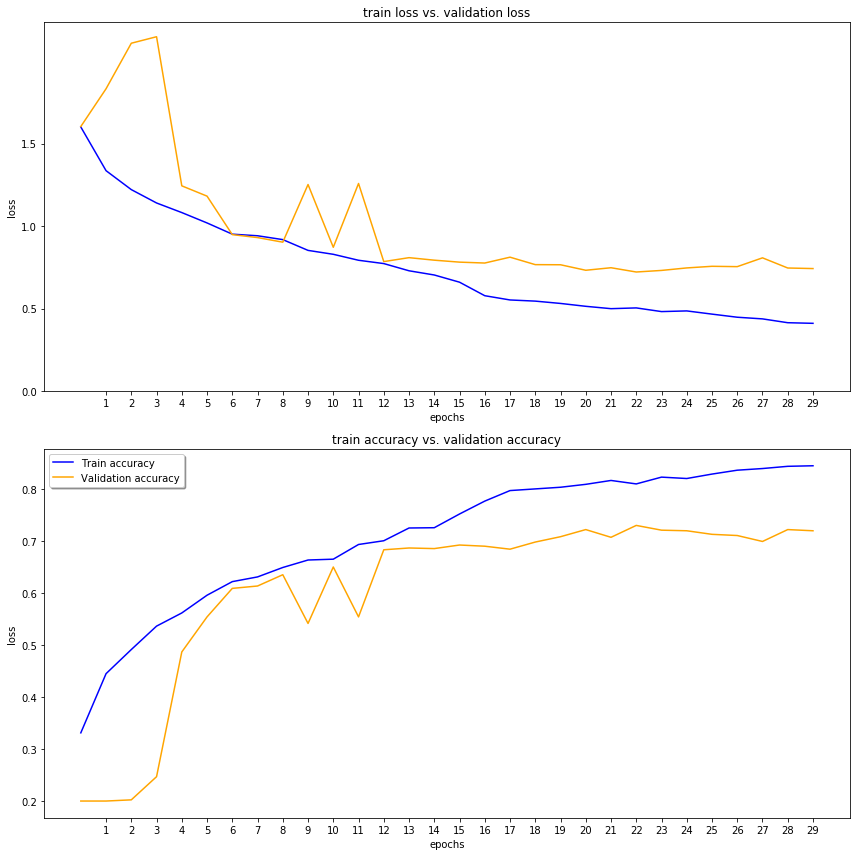

In [17]:
model.save_weights('/Users/flo/Desktop/456/_SEMESTER_PROJECT/saved_models/24.h5')
model.summary()

# evaluate model on test data
#scores = model.evaluate(X_test, y_test, verbose=2)
# verbose indiciator to display training progress info
# 1 (true) (default) | 0 (false)
print(NAME)

scores = model.evaluate(X_valid, y_valid, verbose=2)
print('Valid loss:', scores[0])
print('Valid accuracy:', scores[1])

# scores = model.evaluate(X_test, y_test, verbose=2)
# print('Test loss:', scores[0])
# print('Test accuracy:', scores[1])

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 12))
ax1.plot(hist.history['loss'], color='b', label="Train loss")
ax1.plot(hist.history['val_loss'], color='#ffa500', label="Validation loss")
ax1.set_xticks(np.arange(1, epochs, 1))
ax1.set_yticks(np.arange(0, 2, 0.5))
ax1.set_ylabel('loss')
ax1.set_title('train loss vs. validation loss')
ax1.set_xlabel('epochs')

ax2.plot(hist.history['accuracy'], color='b', label="Train accuracy")
ax2.plot(hist.history['val_accuracy'], color='#ffa500',label="Validation accuracy")
ax2.set_xticks(np.arange(1, epochs, 1))
ax2.set_ylabel('loss')
ax2.set_title('train accuracy vs. validation accuracy')
ax2.set_xlabel('epochs')

legend = plt.legend(loc='best', shadow=True)
plt.tight_layout()
plt.show()

# iteration 23

In [6]:
print("X after normal",X_train[0][0][0])
print("y after normal",y_train[0])

print("X_train shape", X_train.shape)
print("X_valid shape", X_valid.shape)
print("y_train shape", y_train.shape)
print("y_valid shape", y_valid.shape)


_iter = 24
learn_rate = 0.01
epochs = 30
batch_size=32

NAME = "{}-{}-bsz-{}-lr-{}-ep".format(_iter,
                                        batch_size,
                                        learn_rate,
                                        epochs,
                                        int(time.time()))

#log_dir="logs/" + NAME + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
#logdir = os.path.join("logs", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
#tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir)

# specify model
model = Sequential()

# layer 1: Conv1 + Relu + MaxPool
model.add(Conv2D(96, (11,11), strides=4, padding='valid',input_shape = X_train.shape[1:]))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2),strides=2))

# layer 2: Conv2 + Relu + MaxPool
model.add(Conv2D(256, (3,3), strides=1, padding='valid'))
#model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2),strides=2))

# #layer 3: Conv3 + Relu
# model.add(Conv2D(384, (5,5), strides=1, padding='valid'))
# model.add(Activation('relu'))

# # layer 4: Conv4 + Relu
# model.add(Conv2D(384, (3,3), strides=1, padding='valid'))
# model.add(Activation('relu'))

# # layer 5: Conv5 + Relu + MaxPool + Dropout
model.add(Conv2D(256, (3,3), strides=1))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2), strides=2))
#model.add(Dropout(0.50))

# # flatten before dense/fcc
model.add(Flatten())

# # layer 6: FC6 + Relu + Dropout
model.add(Dense(4096))
model.add(Activation('relu'))
#model.add(Dropout(0.50)) #bad to add drop out right before the last layer?

# layer 7: FC7 + Relu
model.add(Dense(4096))
model.add(Activation('relu'))

# layer 8: FC8 + Relu
model.add(Dense(NUM_CLASSES))
model.add(Activation('softmax'))


# optimizer: adjust learning rates
# adam pros: low memory, works well for deep nets
#adam = tf.keras.optimizers.Adam(lr=learn_rate)
opt = optimizers.SGD(lr=learn_rate, momentum=.9)

model.compile(loss="categorical_crossentropy",
              optimizer=opt,
              metrics=['accuracy'])

checkpoint_path = "/Users/flo/Desktop/456/_SEMESTER_PROJECT/checkpoints/"+NAME
checkpointer = ModelCheckpoint(filepath=checkpoint_path+'.{epoch:02d}-{val_loss:.2f}.hdf5', verbose=1, save_best_only=True)

def schedule(epoch):
    if epoch < 15:
        return .01
    elif epoch < 25:
        return .0001
    else:
        return .00001
lr_scheduler = LearningRateScheduler(schedule)

train_datagen = ImageDataGenerator(
    featurewise_center=False,
    featurewise_std_normalization=False,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True)
train_datagen.fit(X_train)

valid_datagen = ImageDataGenerator(
    featurewise_center=False,
    featurewise_std_normalization=False,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True)
valid_datagen.fit(X_valid)

train_generator = train_datagen.flow(X_train, y_train, batch_size=batch_size,shuffle=True)
valid_generator = valid_datagen.flow(X_valid, y_valid, batch_size=batch_size,shuffle=True)

print("Training start ",datetime.datetime.now().strftime("%H:%M:%S"))
hist = model.fit_generator(train_generator,
                           validation_data=valid_generator,
                           epochs=epochs,      # epochs = how many times go through the network
                           steps_per_epoch=X_train.shape[0]//batch_size, # number of batch iterations before an epoch is finished
                           validation_steps=X_valid.shape[0]//batch_size,
                           shuffle=True,
                           callbacks=[lr_scheduler,checkpointer])
print("Training end ",datetime.datetime.now().strftime("%H:%M:%S"))

X after normal [-0.06658942 -0.06641111 -0.06645086]
y after normal [1. 0. 0. 0. 0.]
X_train shape (3750, 227, 227, 3)
X_valid shape (875, 227, 227, 3)
y_train shape (3750, 5)
y_valid shape (875, 5)
Training start  22:51:39
Epoch 1/30
116/117 [============================>.] - ETA: 0s - loss: 1.5009 - accuracy: 0.3307
Epoch 00001: val_loss improved from inf to 1.56857, saving model to /Users/flo/Desktop/456/_SEMESTER_PROJECT/checkpoints/24-32-bsz-0.01-lr-30-ep.01-1.57.hdf5
117/117 [==============================] - 128s 1s/step - loss: 1.4984 - accuracy: 0.3330 - val_loss: 1.5686 - val_accuracy: 0.3692
Epoch 2/30
116/117 [============================>.] - ETA: 0s - loss: 1.3326 - accuracy: 0.4357
Epoch 00002: val_loss improved from 1.56857 to 1.44375, saving model to /Users/flo/Desktop/456/_SEMESTER_PROJECT/checkpoints/24-32-bsz-0.01-lr-30-ep.02-1.44.hdf5
117/117 [==============================] - 127s 1s/step - loss: 1.3329 - accuracy: 0.4349 - val_loss: 1.4437 - val_accuracy: 0.4421


Epoch 24/30
116/117 [============================>.] - ETA: 1s - loss: 0.6460 - accuracy: 0.7604
Epoch 00024: val_loss did not improve from 0.66162
117/117 [==============================] - 137s 1s/step - loss: 0.6449 - accuracy: 0.7603 - val_loss: 0.6654 - val_accuracy: 0.7407
Epoch 25/30
116/117 [============================>.] - ETA: 1s - loss: 0.6214 - accuracy: 0.7642
Epoch 00025: val_loss did not improve from 0.66162
117/117 [==============================] - 139s 1s/step - loss: 0.6205 - accuracy: 0.7644 - val_loss: 0.6852 - val_accuracy: 0.7431
Epoch 26/30
116/117 [============================>.] - ETA: 0s - loss: 0.6099 - accuracy: 0.7721
Epoch 00026: val_loss improved from 0.66162 to 0.64604, saving model to /Users/flo/Desktop/456/_SEMESTER_PROJECT/checkpoints/24-32-bsz-0.01-lr-30-ep.26-0.65.hdf5
117/117 [==============================] - 130s 1s/step - loss: 0.6109 - accuracy: 0.7719 - val_loss: 0.6460 - val_accuracy: 0.7419
Epoch 27/30
116/117 [============================

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 55, 55, 96)        34944     
_________________________________________________________________
batch_normalization_2 (Batch (None, 55, 55, 96)        384       
_________________________________________________________________
activation_6 (Activation)    (None, 55, 55, 96)        0         
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 27, 27, 96)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 25, 25, 256)       221440    
_________________________________________________________________
activation_7 (Activation)    (None, 25, 25, 256)       0         
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 12, 12, 256)      

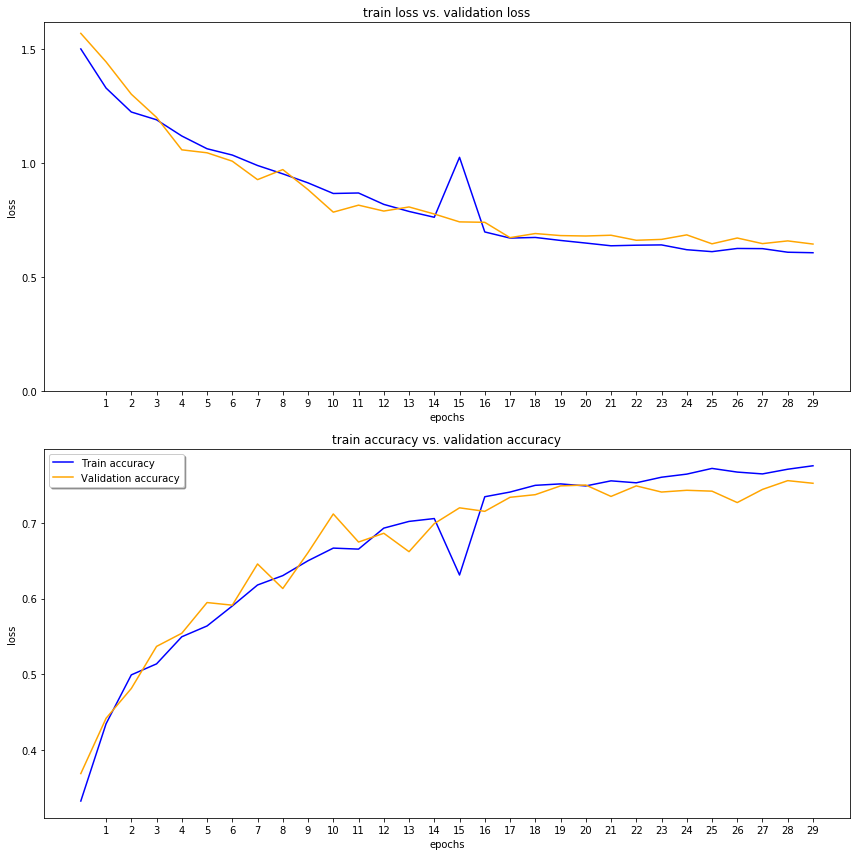

In [11]:
model.save_weights('/Users/flo/Desktop/456/_SEMESTER_PROJECT/saved_models/25.h5')
model.summary()

# evaluate model on test data
#scores = model.evaluate(X_test, y_test, verbose=2)
# verbose indiciator to display training progress info
# 1 (true) (default) | 0 (false)
print(NAME)

scores = model.evaluate(X_valid, y_valid, verbose=2)
print('Valid loss:', scores[0])
print('Valid accuracy:', scores[1])

# scores = model.evaluate(X_test, y_test, verbose=2)
# print('Test loss:', scores[0])
# print('Test accuracy:', scores[1])

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 12))
ax1.plot(hist.history['loss'], color='b', label="Train loss")
ax1.plot(hist.history['val_loss'], color='#ffa500', label="Validation loss")
ax1.set_xticks(np.arange(1, epochs, 1))
ax1.set_yticks(np.arange(0, 2, 0.5))
ax1.set_ylabel('loss')
ax1.set_title('train loss vs. validation loss')
ax1.set_xlabel('epochs')

ax2.plot(hist.history['accuracy'], color='b', label="Train accuracy")
ax2.plot(hist.history['val_accuracy'], color='#ffa500',label="Validation accuracy")
ax2.set_xticks(np.arange(1, epochs, 1))
ax2.set_ylabel('loss')
ax2.set_title('train accuracy vs. validation accuracy')
ax2.set_xlabel('epochs')

legend = plt.legend(loc='best', shadow=True)
plt.tight_layout()
plt.show()

# iteration 24

In [12]:
print("X after normal",X_train[0][0][0])
print("y after normal",y_train[0])

print("X_train shape", X_train.shape)
print("X_valid shape", X_valid.shape)
print("y_train shape", y_train.shape)
print("y_valid shape", y_valid.shape)


_iter = 26
learn_rate = 0.01
epochs = 30
batch_size=32

NAME = "{}-{}-bsz-{}-lr-{}-ep".format(_iter,
                                        batch_size,
                                        learn_rate,
                                        epochs,
                                        int(time.time()))

#log_dir="logs/" + NAME + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
#logdir = os.path.join("logs", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
#tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir)

# specify model
model = Sequential()

# layer 1: Conv1 + Relu + MaxPool
model.add(Conv2D(96, (11,11), strides=4, padding='valid',input_shape = X_train.shape[1:]))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2),strides=2))

# layer 2: Conv2 + Relu + MaxPool
model.add(Conv2D(256, (3,3), strides=1, padding='valid'))
#model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2),strides=2))

# #layer 3: Conv3 + Relu
# model.add(Conv2D(384, (5,5), strides=1, padding='valid'))
# model.add(Activation('relu'))

# # layer 4: Conv4 + Relu
# model.add(Conv2D(384, (3,3), strides=1, padding='valid'))
# model.add(Activation('relu'))

# # layer 5: Conv5 + Relu + MaxPool + Dropout
model.add(Conv2D(256, (3,3), strides=1))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2), strides=2))
#model.add(Dropout(0.50))

# # flatten before dense/fcc
model.add(Flatten())

# # layer 6: FC6 + Relu + Dropout
model.add(Dense(4096))
model.add(Activation('relu'))
#model.add(Dropout(0.50)) #bad to add drop out right before the last layer?

# layer 7: FC7 + Relu
model.add(Dense(4096))
model.add(Activation('relu'))

# layer 8: FC8 + Relu
model.add(Dense(NUM_CLASSES))
model.add(Activation('softmax'))


# optimizer: adjust learning rates
# adam pros: low memory, works well for deep nets
#adam = tf.keras.optimizers.Adam(lr=learn_rate)
opt = optimizers.SGD(lr=learn_rate, momentum=.9)

model.compile(loss="categorical_crossentropy",
              optimizer=opt,
              metrics=['accuracy'])

checkpoint_path = "/Users/flo/Desktop/456/_SEMESTER_PROJECT/checkpoints/"+NAME
checkpointer = ModelCheckpoint(filepath=checkpoint_path+'.{epoch:02d}-{val_loss:.2f}.hdf5', verbose=1, save_best_only=True)

def schedule(epoch):
    if epoch < 15:
        return .01
    elif epoch < 25:
        return .0001
    else:
        return .00005
lr_scheduler = LearningRateScheduler(schedule)

train_datagen = ImageDataGenerator(
    featurewise_center=False,
    featurewise_std_normalization=False,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True)
train_datagen.fit(X_train)

valid_datagen = ImageDataGenerator(
    featurewise_center=False,
    featurewise_std_normalization=False,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True)
valid_datagen.fit(X_valid)

train_generator = train_datagen.flow(X_train, y_train, batch_size=batch_size,shuffle=True)
valid_generator = valid_datagen.flow(X_valid, y_valid, batch_size=batch_size,shuffle=True)

print("Training start ",datetime.datetime.now().strftime("%H:%M:%S"))
hist = model.fit_generator(train_generator,
                           validation_data=valid_generator,
                           epochs=epochs,      # epochs = how many times go through the network
                           steps_per_epoch=X_train.shape[0]//batch_size, # number of batch iterations before an epoch is finished
                           validation_steps=X_valid.shape[0]//batch_size,
                           shuffle=True,
                           callbacks=[lr_scheduler,checkpointer])
print("Training end ",datetime.datetime.now().strftime("%H:%M:%S"))

X after normal [-0.06658942 -0.06641111 -0.06645086]
y after normal [1. 0. 0. 0. 0.]
X_train shape (3750, 227, 227, 3)
X_valid shape (875, 227, 227, 3)
y_train shape (3750, 5)
y_valid shape (875, 5)
Training start  00:17:42
Epoch 1/30
116/117 [============================>.] - ETA: 1s - loss: 1.5037 - accuracy: 0.3207
Epoch 00001: val_loss improved from inf to 1.57791, saving model to /Users/flo/Desktop/456/_SEMESTER_PROJECT/checkpoints/24-32-bsz-0.01-lr-30-ep.01-1.58.hdf5
117/117 [==============================] - 140s 1s/step - loss: 1.5030 - accuracy: 0.3211 - val_loss: 1.5779 - val_accuracy: 0.2523
Epoch 2/30
116/117 [============================>.] - ETA: 1s - loss: 1.3326 - accuracy: 0.4428
Epoch 00002: val_loss improved from 1.57791 to 1.46204, saving model to /Users/flo/Desktop/456/_SEMESTER_PROJECT/checkpoints/24-32-bsz-0.01-lr-30-ep.02-1.46.hdf5
117/117 [==============================] - 137s 1s/step - loss: 1.3330 - accuracy: 0.4416 - val_loss: 1.4620 - val_accuracy: 0.4062


Epoch 24/30
116/117 [============================>.] - ETA: 1s - loss: 0.6268 - accuracy: 0.7642
Epoch 00024: val_loss improved from 0.68267 to 0.67155, saving model to /Users/flo/Desktop/456/_SEMESTER_PROJECT/checkpoints/24-32-bsz-0.01-lr-30-ep.24-0.67.hdf5
117/117 [==============================] - 142s 1s/step - loss: 0.6268 - accuracy: 0.7647 - val_loss: 0.6715 - val_accuracy: 0.7350
Epoch 25/30
116/117 [============================>.] - ETA: 1s - loss: 0.6207 - accuracy: 0.7672
Epoch 00025: val_loss did not improve from 0.67155
117/117 [==============================] - 136s 1s/step - loss: 0.6197 - accuracy: 0.7673 - val_loss: 0.6800 - val_accuracy: 0.7465
Epoch 26/30
116/117 [============================>.] - ETA: 1s - loss: 0.5990 - accuracy: 0.7751
Epoch 00026: val_loss did not improve from 0.67155
117/117 [==============================] - 140s 1s/step - loss: 0.5995 - accuracy: 0.7746 - val_loss: 0.6899 - val_accuracy: 0.7269
Epoch 27/30
116/117 [============================

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            (None, 55, 55, 96)        34944     
_________________________________________________________________
batch_normalization_3 (Batch (None, 55, 55, 96)        384       
_________________________________________________________________
activation_12 (Activation)   (None, 55, 55, 96)        0         
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 27, 27, 96)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 25, 25, 256)       221440    
_________________________________________________________________
activation_13 (Activation)   (None, 25, 25, 256)       0         
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 12, 12, 256)      

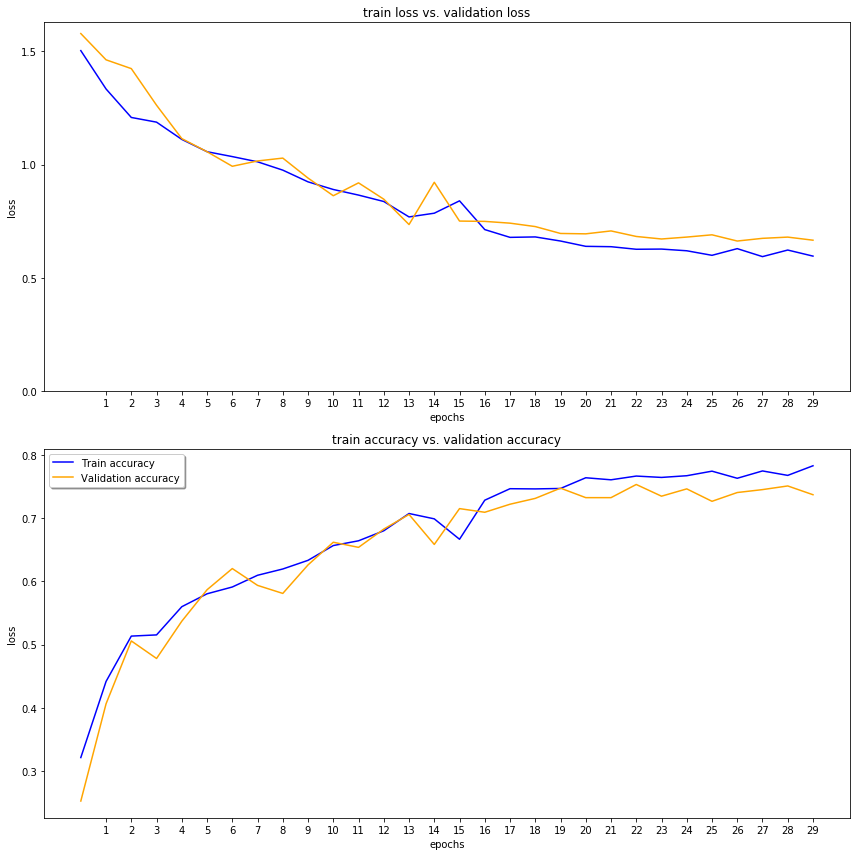

In [13]:
model.save_weights('/Users/flo/Desktop/456/_SEMESTER_PROJECT/saved_models/26.h5')
model.summary()

# evaluate model on test data
#scores = model.evaluate(X_test, y_test, verbose=2)
# verbose indiciator to display training progress info
# 1 (true) (default) | 0 (false)
print(NAME)

scores = model.evaluate(X_valid, y_valid, verbose=2)
print('Valid loss:', scores[0])
print('Valid accuracy:', scores[1])

# scores = model.evaluate(X_test, y_test, verbose=2)
# print('Test loss:', scores[0])
# print('Test accuracy:', scores[1])

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 12))
ax1.plot(hist.history['loss'], color='b', label="Train loss")
ax1.plot(hist.history['val_loss'], color='#ffa500', label="Validation loss")
ax1.set_xticks(np.arange(1, epochs, 1))
ax1.set_yticks(np.arange(0, 2, 0.5))
ax1.set_ylabel('loss')
ax1.set_title('train loss vs. validation loss')
ax1.set_xlabel('epochs')

ax2.plot(hist.history['accuracy'], color='b', label="Train accuracy")
ax2.plot(hist.history['val_accuracy'], color='#ffa500',label="Validation accuracy")
ax2.set_xticks(np.arange(1, epochs, 1))
ax2.set_ylabel('loss')
ax2.set_title('train accuracy vs. validation accuracy')
ax2.set_xlabel('epochs')

legend = plt.legend(loc='best', shadow=True)
plt.tight_layout()
plt.show()

# iteration 25

In [14]:
print("X after normal",X_train[0][0][0])
print("y after normal",y_train[0])

print("X_train shape", X_train.shape)
print("X_valid shape", X_valid.shape)
print("y_train shape", y_train.shape)
print("y_valid shape", y_valid.shape)


_iter = 27
learn_rate = 0.01
epochs = 30
batch_size=32

NAME = "{}-{}-bsz-{}-lr-{}-ep".format(_iter,
                                        batch_size,
                                        learn_rate,
                                        epochs,
                                        int(time.time()))

#log_dir="logs/" + NAME + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
#logdir = os.path.join("logs", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
#tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir)

# specify model
model = Sequential()

# layer 1: Conv1 + Relu + MaxPool
model.add(Conv2D(96, (11,11), strides=4, padding='valid',input_shape = X_train.shape[1:]))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2),strides=2))

# layer 2: Conv2 + Relu + MaxPool
model.add(Conv2D(256, (3,3), strides=1, padding='valid'))
#model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2),strides=2))

# #layer 3: Conv3 + Relu
# model.add(Conv2D(384, (5,5), strides=1, padding='valid'))
# model.add(Activation('relu'))

# # layer 4: Conv4 + Relu
# model.add(Conv2D(384, (3,3), strides=1, padding='valid'))
# model.add(Activation('relu'))

# # layer 5: Conv5 + Relu + MaxPool + Dropout
model.add(Conv2D(256, (3,3), strides=1))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2), strides=2))
#model.add(Dropout(0.50))

# # flatten before dense/fcc
model.add(Flatten())

# # layer 6: FC6 + Relu + Dropout
model.add(Dense(4096))
model.add(Activation('relu'))
#model.add(Dropout(0.50)) #bad to add drop out right before the last layer?

# layer 7: FC7 + Relu
model.add(Dense(4096))
model.add(Activation('relu'))

# layer 8: FC8 + Relu
model.add(Dense(NUM_CLASSES))
model.add(Activation('softmax'))


# optimizer: adjust learning rates
# adam pros: low memory, works well for deep nets
#adam = tf.keras.optimizers.Adam(lr=learn_rate)
opt = optimizers.SGD(lr=learn_rate, momentum=.9)

model.compile(loss="categorical_crossentropy",
              optimizer=opt,
              metrics=['accuracy'])

checkpoint_path = "/Users/flo/Desktop/456/_SEMESTER_PROJECT/checkpoints/"+NAME
checkpointer = ModelCheckpoint(filepath=checkpoint_path+'.{epoch:02d}-{val_loss:.2f}.hdf5', verbose=1, save_best_only=True)

def schedule(epoch):
    if epoch < 15:
        return .01
    elif epoch < 20:
        return .0001
    else:
        return .00005
lr_scheduler = LearningRateScheduler(schedule)

train_datagen = ImageDataGenerator(
    featurewise_center=False,
    featurewise_std_normalization=False,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True)
train_datagen.fit(X_train)

valid_datagen = ImageDataGenerator(
    featurewise_center=False,
    featurewise_std_normalization=False,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True)
valid_datagen.fit(X_valid)

train_generator = train_datagen.flow(X_train, y_train, batch_size=batch_size,shuffle=True)
valid_generator = valid_datagen.flow(X_valid, y_valid, batch_size=batch_size,shuffle=True)

print("Training start ",datetime.datetime.now().strftime("%H:%M:%S"))
hist = model.fit_generator(train_generator,
                           validation_data=valid_generator,
                           epochs=epochs,      # epochs = how many times go through the network
                           steps_per_epoch=X_train.shape[0]//batch_size, # number of batch iterations before an epoch is finished
                           validation_steps=X_valid.shape[0]//batch_size,
                           shuffle=True,
                           callbacks=[lr_scheduler,checkpointer])
print("Training end ",datetime.datetime.now().strftime("%H:%M:%S"))

X after normal [-0.06658942 -0.06641111 -0.06645086]
y after normal [1. 0. 0. 0. 0.]
X_train shape (3750, 227, 227, 3)
X_valid shape (875, 227, 227, 3)
y_train shape (3750, 5)
y_valid shape (875, 5)
Training start  01:31:32
Epoch 1/30
116/117 [============================>.] - ETA: 1s - loss: 1.4882 - accuracy: 0.3405
Epoch 00001: val_loss improved from inf to 1.56240, saving model to /Users/flo/Desktop/456/_SEMESTER_PROJECT/checkpoints/27-32-bsz-0.01-lr-30-ep.01-1.56.hdf5
117/117 [==============================] - 139s 1s/step - loss: 1.4874 - accuracy: 0.3419 - val_loss: 1.5624 - val_accuracy: 0.3704
Epoch 2/30
116/117 [============================>.] - ETA: 1s - loss: 1.3024 - accuracy: 0.4609
Epoch 00002: val_loss improved from 1.56240 to 1.48625, saving model to /Users/flo/Desktop/456/_SEMESTER_PROJECT/checkpoints/27-32-bsz-0.01-lr-30-ep.02-1.49.hdf5
117/117 [==============================] - 134s 1s/step - loss: 1.3021 - accuracy: 0.4605 - val_loss: 1.4862 - val_accuracy: 0.4062


Epoch 25/30
116/117 [============================>.] - ETA: 1s - loss: 0.6146 - accuracy: 0.7699
Epoch 00025: val_loss improved from 0.64903 to 0.64427, saving model to /Users/flo/Desktop/456/_SEMESTER_PROJECT/checkpoints/27-32-bsz-0.01-lr-30-ep.25-0.64.hdf5
117/117 [==============================] - 144s 1s/step - loss: 0.6123 - accuracy: 0.7717 - val_loss: 0.6443 - val_accuracy: 0.7477
Epoch 26/30
116/117 [============================>.] - ETA: 1s - loss: 0.6044 - accuracy: 0.7680
Epoch 00026: val_loss improved from 0.64427 to 0.62786, saving model to /Users/flo/Desktop/456/_SEMESTER_PROJECT/checkpoints/27-32-bsz-0.01-lr-30-ep.26-0.63.hdf5
117/117 [==============================] - 146s 1s/step - loss: 0.6062 - accuracy: 0.7676 - val_loss: 0.6279 - val_accuracy: 0.7650
Epoch 27/30
116/117 [============================>.] - ETA: 1s - loss: 0.5909 - accuracy: 0.7797
Epoch 00027: val_loss did not improve from 0.62786
117/117 [==============================] - 141s 1s/step - loss: 0.5916

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_9 (Conv2D)            (None, 55, 55, 96)        34944     
_________________________________________________________________
batch_normalization_4 (Batch (None, 55, 55, 96)        384       
_________________________________________________________________
activation_18 (Activation)   (None, 55, 55, 96)        0         
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 27, 27, 96)        0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 25, 25, 256)       221440    
_________________________________________________________________
activation_19 (Activation)   (None, 25, 25, 256)       0         
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 12, 12, 256)      

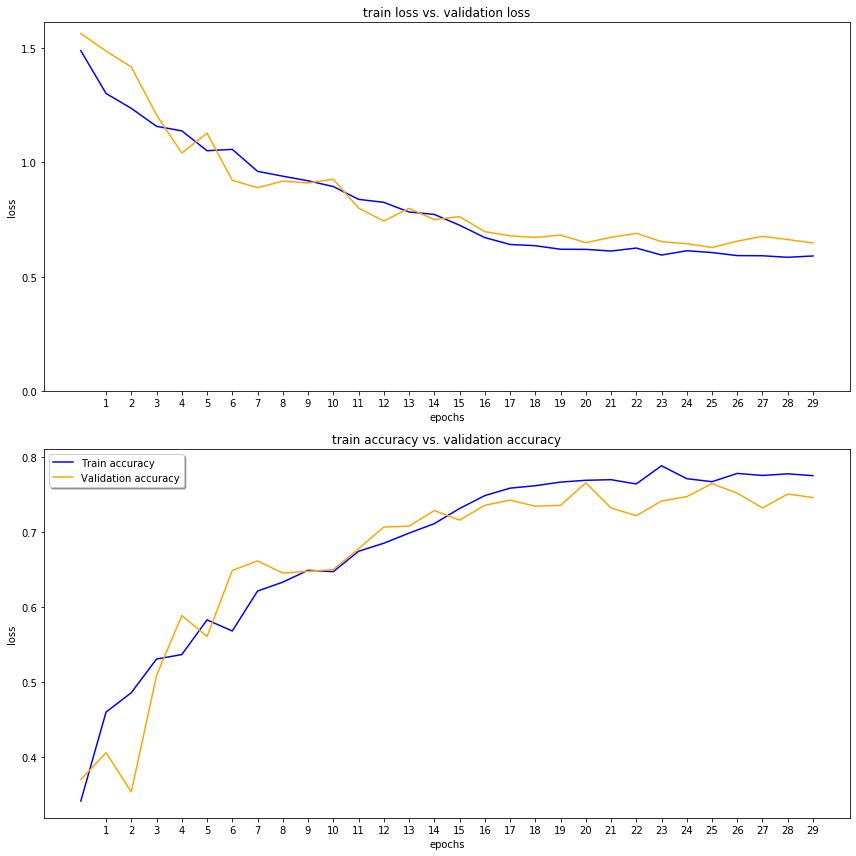

In [15]:
model.save_weights('/Users/flo/Desktop/456/_SEMESTER_PROJECT/saved_models/27.h5')
model.summary()

# evaluate model on test data
#scores = model.evaluate(X_test, y_test, verbose=2)
# verbose indiciator to display training progress info
# 1 (true) (default) | 0 (false)
print(NAME)

scores = model.evaluate(X_valid, y_valid, verbose=2)
print('Valid loss:', scores[0])
print('Valid accuracy:', scores[1])

# scores = model.evaluate(X_test, y_test, verbose=2)
# print('Test loss:', scores[0])
# print('Test accuracy:', scores[1])

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 12))
ax1.plot(hist.history['loss'], color='b', label="Train loss")
ax1.plot(hist.history['val_loss'], color='#ffa500', label="Validation loss")
ax1.set_xticks(np.arange(1, epochs, 1))
ax1.set_yticks(np.arange(0, 2, 0.5))
ax1.set_ylabel('loss')
ax1.set_title('train loss vs. validation loss')
ax1.set_xlabel('epochs')

ax2.plot(hist.history['accuracy'], color='b', label="Train accuracy")
ax2.plot(hist.history['val_accuracy'], color='#ffa500',label="Validation accuracy")
ax2.set_xticks(np.arange(1, epochs, 1))
ax2.set_ylabel('loss')
ax2.set_title('train accuracy vs. validation accuracy')
ax2.set_xlabel('epochs')

legend = plt.legend(loc='best', shadow=True)
plt.tight_layout()
plt.show()

# iteration 26
# alexnet preprocess

In [17]:
NUM_CLASSES = 5
IMG_SIZE = 227
noodle_classes = ['pad_thai','pho','ramen','spaghetti_bolognese','spaghetti_carbonara']

#root_dir = 'food-101/images/'

# this function pre-processes every food image
# and assigns label to the respective food class
# shoves everything into an array called data_set
# shuffles the array
# then separates the data_set array into features array and label array
def create_data(root, _name):
    data_set = []
    features = []
    labels = []
    # pre-process: re-size and re-color
    for noodle_class in noodle_classes:
        path = os.path.join(root, noodle_class)
        label = noodle_classes.index(noodle_class) # FIX LATER: use enumerate
        #print(noodle_class,label)
        #input('wait1')
        for img in os.listdir(path): # pad_thai/1432432.jpg, pad_thai/12314.jpg . . .
            if img.startswith('.'): # .DS_Store
                continue
            # each image is a 2D array of RGB value
            try:
                img_arr = cv2.imread(os.path.join(path,img))
                #img_arr = cv2.imread(os.path.join(path,img))
                new_img = cv2.resize(img_arr, (227, 227))
                #new_img = new_img.astype('float32')
                #plt.imshow(new_img)
                #plt.show()
            
                #print(new_img[:,:,0])
                #rgb_mean = [149.695, 120.739, 89.515]
                new_img[:,:,0] = np.subtract(new_img[:,:,0],149.695)
                new_img[:,:,1] = np.subtract(new_img[:,:,1],120.739)
                new_img[:,:,2] = np.subtract(new_img[:,:,2],89.515)

                #plt.imshow(new_img)
                #plt.show()
                #print(new_img)
                #per_channel_mean = np.mean(new_img, axis=(0))
                #new_img = np.subtract(per_channel_mean,new_img) #i want this cause cv2 inverted

                features.append(new_img)
                labels.append(label) # shove (X,y) in here cause we wanna shuffle 
                #print(data_set)
            except Exception as e:
                print("create exception: ",e,"on",img)

    X = np.array(features).reshape(-1, 227, 227, 3)
    y = np.array(labels).reshape(-1, 1)
    X = X.astype('float32')
    #save(X,y,_name)
    
    return X,y

X_train, y_train = create_data('food-101/train', "train")
X_valid, y_valid = create_data('food-101/valid',"valid")

X_train = tf.keras.utils.normalize(X_train, axis=1)
y_train = tf.keras.utils.to_categorical(y_train, NUM_CLASSES)

X_valid = tf.keras.utils.normalize(X_valid, axis=1)
y_valid = tf.keras.utils.to_categorical(y_valid, NUM_CLASSES)

In [18]:
print("X after normal",X_train[0][0][0])
print("y after normal",y_train[0])

print("X_train shape", X_train.shape)
print("X_valid shape", X_valid.shape)
print("y_train shape", y_train.shape)
print("y_valid shape", y_valid.shape)


_iter = 28
learn_rate = 0.01
epochs = 30
batch_size=32

NAME = "{}-{}-bsz-{}-lr-{}-ep".format(_iter,
                                        batch_size,
                                        learn_rate,
                                        epochs,
                                        int(time.time()))

#log_dir="logs/" + NAME + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
#logdir = os.path.join("logs", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
#tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir)

# specify model
model = Sequential()

# layer 1: Conv1 + Relu + MaxPool
model.add(Conv2D(96, (11,11), strides=4, padding='valid',input_shape = X_train.shape[1:]))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2),strides=2))

# layer 2: Conv2 + Relu + MaxPool
model.add(Conv2D(256, (3,3), strides=1, padding='valid'))
#model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2),strides=2))

# #layer 3: Conv3 + Relu
# model.add(Conv2D(384, (5,5), strides=1, padding='valid'))
# model.add(Activation('relu'))

# # layer 4: Conv4 + Relu
# model.add(Conv2D(384, (3,3), strides=1, padding='valid'))
# model.add(Activation('relu'))

# # layer 5: Conv5 + Relu + MaxPool + Dropout
model.add(Conv2D(256, (3,3), strides=1))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2), strides=2))
#model.add(Dropout(0.50))

# # flatten before dense/fcc
model.add(Flatten())

# # layer 6: FC6 + Relu + Dropout
model.add(Dense(4096))
model.add(Activation('relu'))
#model.add(Dropout(0.50)) #bad to add drop out right before the last layer?

# layer 7: FC7 + Relu
model.add(Dense(4096))
model.add(Activation('relu'))

# layer 8: FC8 + Relu
model.add(Dense(NUM_CLASSES))
model.add(Activation('softmax'))


# optimizer: adjust learning rates
# adam pros: low memory, works well for deep nets
#adam = tf.keras.optimizers.Adam(lr=learn_rate)
opt = optimizers.SGD(lr=learn_rate, momentum=.9)

model.compile(loss="categorical_crossentropy",
              optimizer=opt,
              metrics=['accuracy'])

checkpoint_path = "/Users/flo/Desktop/456/_SEMESTER_PROJECT/checkpoints/"+NAME
checkpointer = ModelCheckpoint(filepath=checkpoint_path+'.{epoch:02d}-{val_loss:.2f}.hdf5', verbose=1, save_best_only=True)

def schedule(epoch):
    if epoch < 15:
        return .01
    elif epoch < 20:
        return .0001
    else:
        return .00005
lr_scheduler = LearningRateScheduler(schedule)

train_datagen = ImageDataGenerator(
    featurewise_center=False,
    featurewise_std_normalization=False,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True)
train_datagen.fit(X_train)

valid_datagen = ImageDataGenerator(
    featurewise_center=False,
    featurewise_std_normalization=False,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True)
valid_datagen.fit(X_valid)

train_generator = train_datagen.flow(X_train, y_train, batch_size=batch_size,shuffle=True)
valid_generator = valid_datagen.flow(X_valid, y_valid, batch_size=batch_size,shuffle=True)

print("Training start ",datetime.datetime.now().strftime("%H:%M:%S"))
hist = model.fit_generator(train_generator,
                           validation_data=valid_generator,
                           epochs=epochs,      # epochs = how many times go through the network
                           steps_per_epoch=X_train.shape[0]//batch_size, # number of batch iterations before an epoch is finished
                           validation_steps=X_valid.shape[0]//batch_size,
                           shuffle=True,
                           callbacks=[lr_scheduler,checkpointer])
print("Training end ",datetime.datetime.now().strftime("%H:%M:%S"))

X after normal [0.06666281 0.0664093  0.06641824]
y after normal [1. 0. 0. 0. 0.]
X_train shape (3750, 227, 227, 3)
X_valid shape (875, 227, 227, 3)
y_train shape (3750, 5)
y_valid shape (875, 5)
Training start  02:49:05
Epoch 1/30
116/117 [============================>.] - ETA: 1s - loss: 1.5359 - accuracy: 0.3139
Epoch 00001: val_loss improved from inf to 1.60793, saving model to /Users/flo/Desktop/456/_SEMESTER_PROJECT/checkpoints/27-32-bsz-0.01-lr-30-ep.01-1.61.hdf5
117/117 [==============================] - 140s 1s/step - loss: 1.5354 - accuracy: 0.3147 - val_loss: 1.6079 - val_accuracy: 0.1933
Epoch 2/30
116/117 [============================>.] - ETA: 1s - loss: 1.3921 - accuracy: 0.3999
Epoch 00002: val_loss improved from 1.60793 to 1.58646, saving model to /Users/flo/Desktop/456/_SEMESTER_PROJECT/checkpoints/27-32-bsz-0.01-lr-30-ep.02-1.59.hdf5
117/117 [==============================] - 139s 1s/step - loss: 1.3906 - accuracy: 0.4010 - val_loss: 1.5865 - val_accuracy: 0.2488
Epo

117/117 [==============================] - 137s 1s/step - loss: 0.8490 - accuracy: 0.6711 - val_loss: 0.9294 - val_accuracy: 0.6470
Epoch 25/30
116/117 [============================>.] - ETA: 1s - loss: 0.8614 - accuracy: 0.6628
Epoch 00025: val_loss did not improve from 0.92940
117/117 [==============================] - 146s 1s/step - loss: 0.8628 - accuracy: 0.6619 - val_loss: 0.9419 - val_accuracy: 0.6331
Epoch 26/30
116/117 [============================>.] - ETA: 1s - loss: 0.8403 - accuracy: 0.6734
Epoch 00026: val_loss did not improve from 0.92940
117/117 [==============================] - 134s 1s/step - loss: 0.8396 - accuracy: 0.6740 - val_loss: 0.9552 - val_accuracy: 0.6215
Epoch 27/30
116/117 [============================>.] - ETA: 1s - loss: 0.8469 - accuracy: 0.6595
Epoch 00027: val_loss did not improve from 0.92940
117/117 [==============================] - 132s 1s/step - loss: 0.8446 - accuracy: 0.6611 - val_loss: 0.9388 - val_accuracy: 0.6250
Epoch 28/30
116/117 [=======

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_12 (Conv2D)           (None, 55, 55, 96)        34944     
_________________________________________________________________
batch_normalization_5 (Batch (None, 55, 55, 96)        384       
_________________________________________________________________
activation_24 (Activation)   (None, 55, 55, 96)        0         
_________________________________________________________________
max_pooling2d_12 (MaxPooling (None, 27, 27, 96)        0         
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 25, 25, 256)       221440    
_________________________________________________________________
activation_25 (Activation)   (None, 25, 25, 256)       0         
_________________________________________________________________
max_pooling2d_13 (MaxPooling (None, 12, 12, 256)      

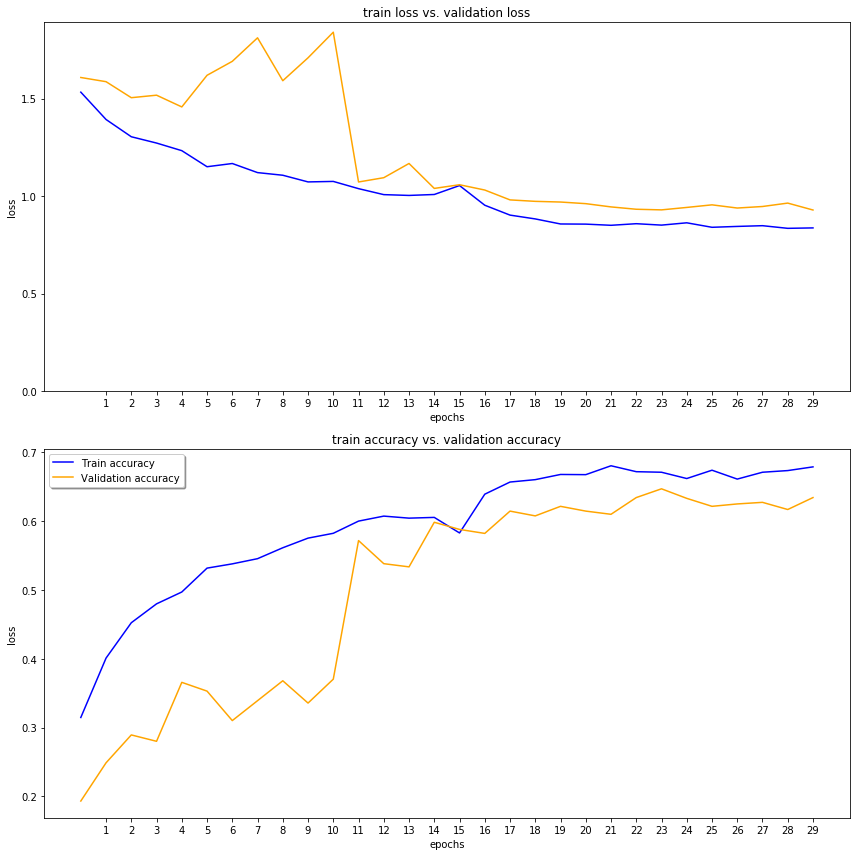

In [19]:
model.save_weights('/Users/flo/Desktop/456/_SEMESTER_PROJECT/saved_models/28.h5')
model.summary()

# evaluate model on test data
#scores = model.evaluate(X_test, y_test, verbose=2)
# verbose indiciator to display training progress info
# 1 (true) (default) | 0 (false)
print(NAME)

scores = model.evaluate(X_valid, y_valid, verbose=2)
print('Valid loss:', scores[0])
print('Valid accuracy:', scores[1])

# scores = model.evaluate(X_test, y_test, verbose=2)
# print('Test loss:', scores[0])
# print('Test accuracy:', scores[1])

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 12))
ax1.plot(hist.history['loss'], color='b', label="Train loss")
ax1.plot(hist.history['val_loss'], color='#ffa500', label="Validation loss")
ax1.set_xticks(np.arange(1, epochs, 1))
ax1.set_yticks(np.arange(0, 2, 0.5))
ax1.set_ylabel('loss')
ax1.set_title('train loss vs. validation loss')
ax1.set_xlabel('epochs')

ax2.plot(hist.history['accuracy'], color='b', label="Train accuracy")
ax2.plot(hist.history['val_accuracy'], color='#ffa500',label="Validation accuracy")
ax2.set_xticks(np.arange(1, epochs, 1))
ax2.set_ylabel('loss')
ax2.set_title('train accuracy vs. validation accuracy')
ax2.set_xlabel('epochs')

legend = plt.legend(loc='best', shadow=True)
plt.tight_layout()
plt.show()

# iteration 27
# mean image preprocess

In [20]:
NUM_CLASSES = 5
IMG_SIZE = 227
noodle_classes = ['pad_thai','pho','ramen','spaghetti_bolognese','spaghetti_carbonara']

#root_dir = 'food-101/images/'

# this function pre-processes every food image
# and assigns label to the respective food class
# shoves everything into an array called data_set
# shuffles the array
# then separates the data_set array into features array and label array
def create_data(root, _name):
    data_set = []
    features = []
    labels = []
    # pre-process: re-size and re-color
    for noodle_class in noodle_classes:
        path = os.path.join(root, noodle_class)
        label = noodle_classes.index(noodle_class) # FIX LATER: use enumerate
        #print(noodle_class,label)
        #input('wait1')
        for img in os.listdir(path): # pad_thai/1432432.jpg, pad_thai/12314.jpg . . .
            if img.startswith('.'): # .DS_Store
                continue
            # each image is a 2D array of RGB value
            try:
                img_arr = cv2.imread(os.path.join(path,img))
                #img_arr = cv2.imread(os.path.join(path,img))
                new_img = cv2.resize(img_arr, (227, 227))
                #new_img = new_img.astype('float32')
                #plt.imshow(new_img)
                #plt.show()
            
                #print(new_img[:,:,0])
                #rgb_mean = [149.695, 120.739, 89.515]
                new_img = new_img.astype('float32')
                new_img = np.subtract(np.mean(new_img),new_img)

                #plt.imshow(new_img)
                #plt.show()
                #print(new_img)
                #per_channel_mean = np.mean(new_img, axis=(0))
                #new_img = np.subtract(per_channel_mean,new_img) #i want this cause cv2 inverted

                features.append(new_img)
                labels.append(label) # shove (X,y) in here cause we wanna shuffle 
                #print(data_set)
            except Exception as e:
                print("create exception: ",e,"on",img)

    X = np.array(features).reshape(-1, 227, 227, 3)
    y = np.array(labels).reshape(-1, 1)
    X = X.astype('float32')
    #save(X,y,_name)
    
    return X,y

X_train, y_train = create_data('food-101/train', "train")
X_valid, y_valid = create_data('food-101/valid',"valid")

X_train = tf.keras.utils.normalize(X_train, axis=1)
y_train = tf.keras.utils.to_categorical(y_train, NUM_CLASSES)

X_valid = tf.keras.utils.normalize(X_valid, axis=1)
y_valid = tf.keras.utils.to_categorical(y_valid, NUM_CLASSES)

In [21]:
print("X after normal",X_train[0][0][0])
print("y after normal",y_train[0])

print("X_train shape", X_train.shape)
print("X_valid shape", X_valid.shape)
print("y_train shape", y_train.shape)
print("y_valid shape", y_valid.shape)


_iter = 29
learn_rate = 0.01
epochs = 30
batch_size=32

NAME = "{}-{}-bsz-{}-lr-{}-ep".format(_iter,
                                        batch_size,
                                        learn_rate,
                                        epochs,
                                        int(time.time()))

#log_dir="logs/" + NAME + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
#logdir = os.path.join("logs", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
#tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir)

# specify model
model = Sequential()

# layer 1: Conv1 + Relu + MaxPool
model.add(Conv2D(96, (11,11), strides=4, padding='valid',input_shape = X_train.shape[1:]))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2),strides=2))

# layer 2: Conv2 + Relu + MaxPool
model.add(Conv2D(256, (3,3), strides=1, padding='valid'))
#model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2),strides=2))

# #layer 3: Conv3 + Relu
# model.add(Conv2D(384, (5,5), strides=1, padding='valid'))
# model.add(Activation('relu'))

# # layer 4: Conv4 + Relu
# model.add(Conv2D(384, (3,3), strides=1, padding='valid'))
# model.add(Activation('relu'))

# # layer 5: Conv5 + Relu + MaxPool + Dropout
model.add(Conv2D(256, (3,3), strides=1))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2), strides=2))
#model.add(Dropout(0.50))

# # flatten before dense/fcc
model.add(Flatten())

# # layer 6: FC6 + Relu + Dropout
model.add(Dense(4096))
model.add(Activation('relu'))
#model.add(Dropout(0.50)) #bad to add drop out right before the last layer?

# layer 7: FC7 + Relu
model.add(Dense(4096))
model.add(Activation('relu'))

# layer 8: FC8 + Relu
model.add(Dense(NUM_CLASSES))
model.add(Activation('softmax'))


# optimizer: adjust learning rates
# adam pros: low memory, works well for deep nets
#adam = tf.keras.optimizers.Adam(lr=learn_rate)
opt = optimizers.SGD(lr=learn_rate, momentum=.9)

model.compile(loss="categorical_crossentropy",
              optimizer=opt,
              metrics=['accuracy'])

checkpoint_path = "/Users/flo/Desktop/456/_SEMESTER_PROJECT/checkpoints/"+NAME
checkpointer = ModelCheckpoint(filepath=checkpoint_path+'.{epoch:02d}-{val_loss:.2f}.hdf5', verbose=1, save_best_only=True)

def schedule(epoch):
    if epoch < 15:
        return .01
    elif epoch < 20:
        return .0001
    else:
        return .00005
lr_scheduler = LearningRateScheduler(schedule)

train_datagen = ImageDataGenerator(
    featurewise_center=False,
    featurewise_std_normalization=False,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True)
train_datagen.fit(X_train)

valid_datagen = ImageDataGenerator(
    featurewise_center=False,
    featurewise_std_normalization=False,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True)
valid_datagen.fit(X_valid)

train_generator = train_datagen.flow(X_train, y_train, batch_size=batch_size,shuffle=True)
valid_generator = valid_datagen.flow(X_valid, y_valid, batch_size=batch_size,shuffle=True)

print("Training start ",datetime.datetime.now().strftime("%H:%M:%S"))
hist = model.fit_generator(train_generator,
                           validation_data=valid_generator,
                           epochs=epochs,      # epochs = how many times go through the network
                           steps_per_epoch=X_train.shape[0]//batch_size, # number of batch iterations before an epoch is finished
                           validation_steps=X_valid.shape[0]//batch_size,
                           shuffle=True,
                           callbacks=[lr_scheduler,checkpointer])
print("Training end ",datetime.datetime.now().strftime("%H:%M:%S"))

X after normal [-0.06663409 -0.06641479 -0.06643718]
y after normal [1. 0. 0. 0. 0.]
X_train shape (3750, 227, 227, 3)
X_valid shape (875, 227, 227, 3)
y_train shape (3750, 5)
y_valid shape (875, 5)
Training start  03:59:36
Epoch 1/30
116/117 [============================>.] - ETA: 1s - loss: 1.4595 - accuracy: 0.3540
Epoch 00001: val_loss improved from inf to 1.55612, saving model to /Users/flo/Desktop/456/_SEMESTER_PROJECT/checkpoints/29-32-bsz-0.01-lr-30-ep.01-1.56.hdf5
117/117 [==============================] - 138s 1s/step - loss: 1.4600 - accuracy: 0.3529 - val_loss: 1.5561 - val_accuracy: 0.4155
Epoch 2/30
116/117 [============================>.] - ETA: 0s - loss: 1.3312 - accuracy: 0.4436
Epoch 00002: val_loss improved from 1.55612 to 1.47575, saving model to /Users/flo/Desktop/456/_SEMESTER_PROJECT/checkpoints/29-32-bsz-0.01-lr-30-ep.02-1.48.hdf5
117/117 [==============================] - 127s 1s/step - loss: 1.3301 - accuracy: 0.4443 - val_loss: 1.4758 - val_accuracy: 0.4248


Epoch 24/30
116/117 [============================>.] - ETA: 0s - loss: 0.7005 - accuracy: 0.7409
Epoch 00024: val_loss did not improve from 0.77803
117/117 [==============================] - 125s 1s/step - loss: 0.6999 - accuracy: 0.7415 - val_loss: 0.7815 - val_accuracy: 0.6887
Epoch 25/30
116/117 [============================>.] - ETA: 0s - loss: 0.7017 - accuracy: 0.7306
Epoch 00025: val_loss improved from 0.77803 to 0.75529, saving model to /Users/flo/Desktop/456/_SEMESTER_PROJECT/checkpoints/29-32-bsz-0.01-lr-30-ep.25-0.76.hdf5
117/117 [==============================] - 126s 1s/step - loss: 0.7018 - accuracy: 0.7308 - val_loss: 0.7553 - val_accuracy: 0.7083
Epoch 26/30
116/117 [============================>.] - ETA: 0s - loss: 0.7052 - accuracy: 0.7404
Epoch 00026: val_loss improved from 0.75529 to 0.74661, saving model to /Users/flo/Desktop/456/_SEMESTER_PROJECT/checkpoints/29-32-bsz-0.01-lr-30-ep.26-0.75.hdf5
117/117 [==============================] - 126s 1s/step - loss: 0.7056

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_15 (Conv2D)           (None, 55, 55, 96)        34944     
_________________________________________________________________
batch_normalization_6 (Batch (None, 55, 55, 96)        384       
_________________________________________________________________
activation_30 (Activation)   (None, 55, 55, 96)        0         
_________________________________________________________________
max_pooling2d_15 (MaxPooling (None, 27, 27, 96)        0         
_________________________________________________________________
conv2d_16 (Conv2D)           (None, 25, 25, 256)       221440    
_________________________________________________________________
activation_31 (Activation)   (None, 25, 25, 256)       0         
_________________________________________________________________
max_pooling2d_16 (MaxPooling (None, 12, 12, 256)      

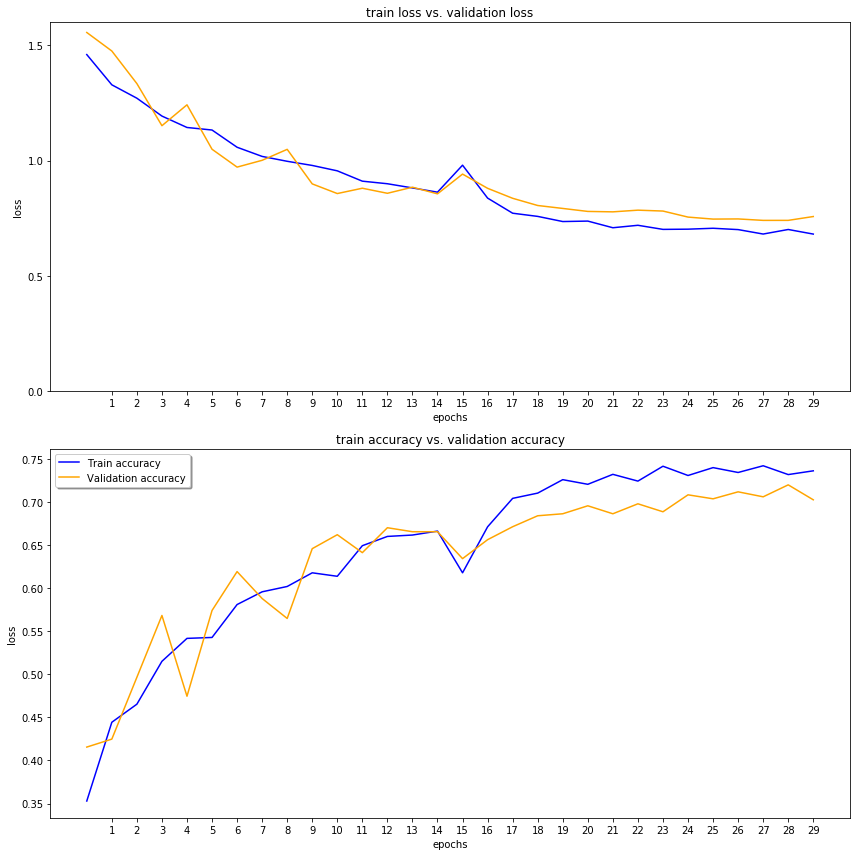

In [22]:
model.save_weights('/Users/flo/Desktop/456/_SEMESTER_PROJECT/saved_models/29.h5')
model.summary()

# evaluate model on test data
#scores = model.evaluate(X_test, y_test, verbose=2)
# verbose indiciator to display training progress info
# 1 (true) (default) | 0 (false)
print(NAME)

scores = model.evaluate(X_valid, y_valid, verbose=2)
print('Valid loss:', scores[0])
print('Valid accuracy:', scores[1])

# scores = model.evaluate(X_test, y_test, verbose=2)
# print('Test loss:', scores[0])
# print('Test accuracy:', scores[1])

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 12))
ax1.plot(hist.history['loss'], color='b', label="Train loss")
ax1.plot(hist.history['val_loss'], color='#ffa500', label="Validation loss")
ax1.set_xticks(np.arange(1, epochs, 1))
ax1.set_yticks(np.arange(0, 2, 0.5))
ax1.set_ylabel('loss')
ax1.set_title('train loss vs. validation loss')
ax1.set_xlabel('epochs')

ax2.plot(hist.history['accuracy'], color='b', label="Train accuracy")
ax2.plot(hist.history['val_accuracy'], color='#ffa500',label="Validation accuracy")
ax2.set_xticks(np.arange(1, epochs, 1))
ax2.set_ylabel('loss')
ax2.set_title('train accuracy vs. validation accuracy')
ax2.set_xlabel('epochs')

legend = plt.legend(loc='best', shadow=True)
plt.tight_layout()
plt.show()

# iteration 28
# fine tune best model
# add drop out

In [23]:

NUM_CLASSES = 5
noodle_classes = ['pad_thai','pho','ramen','spaghetti_bolognese','spaghetti_carbonara']

#root_dir = 'food-101/images/'

# this function pre-processes every food image
# and assigns label to the respective food class
# shoves everything into an array called data_set
# shuffles the array
# then separates the data_set array into features array and label array
def create_data(root, _name):
    data_set = []
    features = []
    labels = []
    # pre-process: re-size and re-color
    for noodle_class in noodle_classes:
        path = os.path.join(root, noodle_class)
        label = noodle_classes.index(noodle_class) # FIX LATER: use enumerate
        #print(noodle_class,label)
        #input('wait1')
        for img in os.listdir(path): # pad_thai/1432432.jpg, pad_thai/12314.jpg . . .
            if img.startswith('.'): # .DS_Store
                continue
            # each image is a 2D array of RGB value
            try:
                img_arr = cv2.imread(os.path.join(path,img))
                new_img = cv2.resize(img_arr, (IMG_SIZE, IMG_SIZE))
                new_img = new_img.astype('float32')
                per_channel_mean = np.mean(new_img, axis=(0))
                new_img = np.subtract(per_channel_mean,new_img) #i want this cause cv2 inverted
                
                #plt.imshow(resized_img)
                #plt.show()

                features.append(new_img)
                labels.append(label) # shove (X,y) in here cause we wanna shuffle 
                #print(data_set)
            except Exception as e:
                print("create exception: ",e,"on",img)

        

    X = np.array(features).reshape(-1, 227, 227, 3)
    y = np.array(labels).reshape(-1, 1)
    X = X.astype('float32')
    #save(X,y,_name)
    
    return X,y

X_train, y_train = create_data('food-101/train', "train")
X_valid, y_valid = create_data('food-101/valid',"valid")

X_train = tf.keras.utils.normalize(X_train, axis=1)
y_train = tf.keras.utils.to_categorical(y_train, NUM_CLASSES)

X_valid = tf.keras.utils.normalize(X_valid, axis=1)
y_valid = tf.keras.utils.to_categorical(y_valid, NUM_CLASSES)

In [24]:
print("X after normal",X_train[0][0][0])
print("y after normal",y_train[0])

print("X_train shape", X_train.shape)
print("X_valid shape", X_valid.shape)
print("y_train shape", y_train.shape)
print("y_valid shape", y_valid.shape)


_iter = 30
learn_rate = 0.01
epochs = 30
batch_size=32

NAME = "{}-{}-bsz-{}-lr-{}-ep".format(_iter,
                                        batch_size,
                                        learn_rate,
                                        epochs,
                                        int(time.time()))

#log_dir="logs/" + NAME + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
#logdir = os.path.join("logs", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
#tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir)

# specify model
model = Sequential()

# layer 1: Conv1 + Relu + MaxPool
model.add(Conv2D(96, (11,11), strides=4, padding='valid',input_shape = X_train.shape[1:]))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2),strides=2))

# layer 2: Conv2 + Relu + MaxPool
model.add(Conv2D(256, (3,3), strides=1, padding='valid'))
#model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2),strides=2))

# #layer 3: Conv3 + Relu
# model.add(Conv2D(384, (5,5), strides=1, padding='valid'))
# model.add(Activation('relu'))

# # layer 4: Conv4 + Relu
# model.add(Conv2D(384, (3,3), strides=1, padding='valid'))
# model.add(Activation('relu'))

# # layer 5: Conv5 + Relu + MaxPool + Dropout
model.add(Conv2D(256, (3,3), strides=1))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2), strides=2))
model.add(Dropout(0.25))

# # flatten before dense/fcc
model.add(Flatten())

# # layer 6: FC6 + Relu + Dropout
model.add(Dense(4096))
model.add(Activation('relu'))
#model.add(Dropout(0.50)) #bad to add drop out right before the last layer?

# layer 7: FC7 + Relu
model.add(Dense(4096))
model.add(Activation('relu'))

# layer 8: FC8 + Relu
model.add(Dense(NUM_CLASSES))
model.add(Activation('softmax'))


# optimizer: adjust learning rates
# adam pros: low memory, works well for deep nets
#adam = tf.keras.optimizers.Adam(lr=learn_rate)
opt = optimizers.SGD(lr=learn_rate, momentum=.9)

model.compile(loss="categorical_crossentropy",
              optimizer=opt,
              metrics=['accuracy'])

#checkpoint_path = "/Users/flo/Desktop/456/_SEMESTER_PROJECT/checkpoints/"+NAME
#checkpointer = ModelCheckpoint(filepath=checkpoint_path+'.{epoch:02d}-{val_loss:.2f}.hdf5', verbose=1, save_best_only=True)

def schedule(epoch):
    if epoch < 15:
        return .01
    elif epoch < 25:
        return .0001
    else:
        return .00005
lr_scheduler = LearningRateScheduler(schedule)

train_datagen = ImageDataGenerator(
    featurewise_center=False,
    featurewise_std_normalization=False,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True)
train_datagen.fit(X_train)

valid_datagen = ImageDataGenerator(
    featurewise_center=False,
    featurewise_std_normalization=False,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True)
valid_datagen.fit(X_valid)

train_generator = train_datagen.flow(X_train, y_train, batch_size=batch_size,shuffle=True)
valid_generator = valid_datagen.flow(X_valid, y_valid, batch_size=batch_size,shuffle=True)

print("Training start ",datetime.datetime.now().strftime("%H:%M:%S"))
hist = model.fit_generator(train_generator,
                           validation_data=valid_generator,
                           epochs=epochs,      # epochs = how many times go through the network
                           steps_per_epoch=X_train.shape[0]//batch_size, # number of batch iterations before an epoch is finished
                           validation_steps=X_valid.shape[0]//batch_size,
                           shuffle=True,
                           callbacks=[lr_scheduler])
print("Training end ",datetime.datetime.now().strftime("%H:%M:%S"))

X after normal [-0.02995581 -0.01778729 -0.01882338]
y after normal [1. 0. 0. 0. 0.]
X_train shape (3750, 227, 227, 3)
X_valid shape (875, 227, 227, 3)
y_train shape (3750, 5)
y_valid shape (875, 5)
Training start  05:03:42
Epoch 1/30
117/117 [==============================] - 127s 1s/step - loss: 1.5093 - accuracy: 0.3362 - val_loss: 1.5820 - val_accuracy: 0.3125
Epoch 2/30
117/117 [==============================] - 126s 1s/step - loss: 1.3611 - accuracy: 0.4242 - val_loss: 1.5043 - val_accuracy: 0.3241
Epoch 3/30
117/117 [==============================] - 126s 1s/step - loss: 1.2616 - accuracy: 0.4750 - val_loss: 1.3220 - val_accuracy: 0.4271
Epoch 4/30
117/117 [==============================] - 125s 1s/step - loss: 1.1942 - accuracy: 0.5134 - val_loss: 1.1819 - val_accuracy: 0.5347
Epoch 5/30
117/117 [==============================] - 125s 1s/step - loss: 1.1456 - accuracy: 0.5355 - val_loss: 1.2549 - val_accuracy: 0.4387
Epoch 6/30
117/117 [==============================] - 125s 1s

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_18 (Conv2D)           (None, 55, 55, 96)        34944     
_________________________________________________________________
batch_normalization_7 (Batch (None, 55, 55, 96)        384       
_________________________________________________________________
activation_36 (Activation)   (None, 55, 55, 96)        0         
_________________________________________________________________
max_pooling2d_18 (MaxPooling (None, 27, 27, 96)        0         
_________________________________________________________________
conv2d_19 (Conv2D)           (None, 25, 25, 256)       221440    
_________________________________________________________________
activation_37 (Activation)   (None, 25, 25, 256)       0         
_________________________________________________________________
max_pooling2d_19 (MaxPooling (None, 12, 12, 256)      

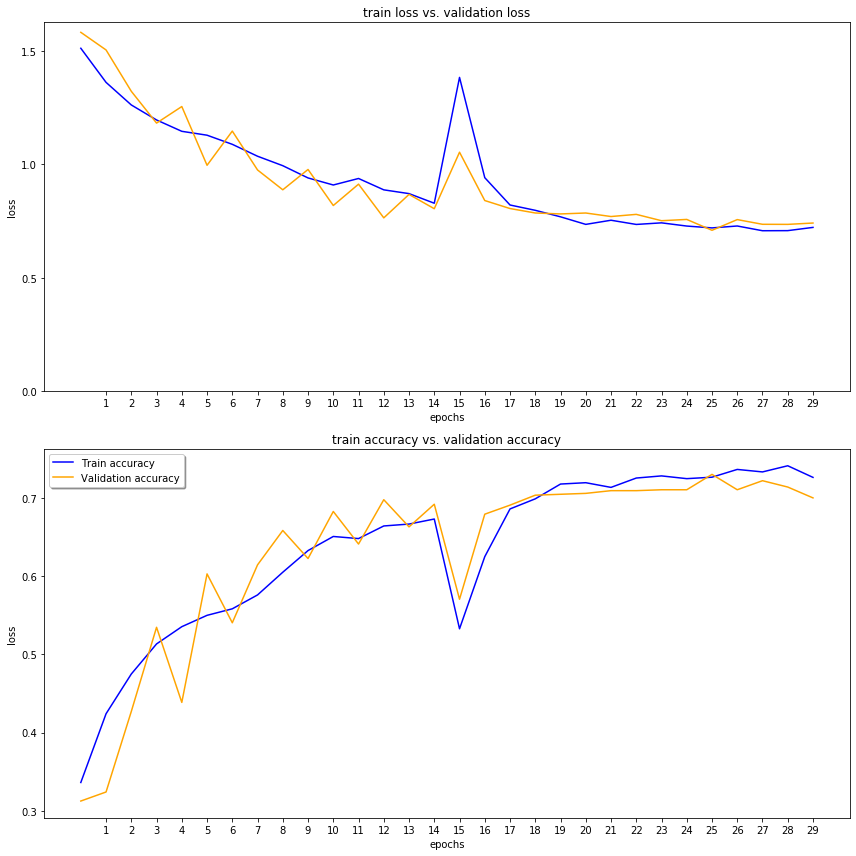

In [25]:
model.save_weights('/Users/flo/Desktop/456/_SEMESTER_PROJECT/saved_models/30.h5')
model.summary()

# evaluate model on test data
#scores = model.evaluate(X_test, y_test, verbose=2)
# verbose indiciator to display training progress info
# 1 (true) (default) | 0 (false)
print(NAME)

scores = model.evaluate(X_valid, y_valid, verbose=2)
print('Valid loss:', scores[0])
print('Valid accuracy:', scores[1])

# scores = model.evaluate(X_test, y_test, verbose=2)
# print('Test loss:', scores[0])
# print('Test accuracy:', scores[1])

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 12))
ax1.plot(hist.history['loss'], color='b', label="Train loss")
ax1.plot(hist.history['val_loss'], color='#ffa500', label="Validation loss")
ax1.set_xticks(np.arange(1, epochs, 1))
ax1.set_yticks(np.arange(0, 2, 0.5))
ax1.set_ylabel('loss')
ax1.set_title('train loss vs. validation loss')
ax1.set_xlabel('epochs')

ax2.plot(hist.history['accuracy'], color='b', label="Train accuracy")
ax2.plot(hist.history['val_accuracy'], color='#ffa500',label="Validation accuracy")
ax2.set_xticks(np.arange(1, epochs, 1))
ax2.set_ylabel('loss')
ax2.set_title('train accuracy vs. validation accuracy')
ax2.set_xlabel('epochs')

legend = plt.legend(loc='best', shadow=True)
plt.tight_layout()
plt.show()

# iteration 29
# fine tune best model
# different learning rate with the drop out

In [26]:
print("X after normal",X_train[0][0][0])
print("y after normal",y_train[0])

print("X_train shape", X_train.shape)
print("X_valid shape", X_valid.shape)
print("y_train shape", y_train.shape)
print("y_valid shape", y_valid.shape)


_iter = 31
learn_rate = 0.01
epochs = 30
batch_size=32

NAME = "{}-{}-bsz-{}-lr-{}-ep".format(_iter,
                                        batch_size,
                                        learn_rate,
                                        epochs,
                                        int(time.time()))

#log_dir="logs/" + NAME + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
#logdir = os.path.join("logs", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
#tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir)

# specify model
model = Sequential()

# layer 1: Conv1 + Relu + MaxPool
model.add(Conv2D(96, (11,11), strides=4, padding='valid',input_shape = X_train.shape[1:]))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2),strides=2))

# layer 2: Conv2 + Relu + MaxPool
model.add(Conv2D(256, (3,3), strides=1, padding='valid'))
#model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2),strides=2))

# #layer 3: Conv3 + Relu
# model.add(Conv2D(384, (5,5), strides=1, padding='valid'))
# model.add(Activation('relu'))

# # layer 4: Conv4 + Relu
# model.add(Conv2D(384, (3,3), strides=1, padding='valid'))
# model.add(Activation('relu'))

# # layer 5: Conv5 + Relu + MaxPool + Dropout
model.add(Conv2D(256, (3,3), strides=1))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2), strides=2))
model.add(Dropout(0.25))

# # flatten before dense/fcc
model.add(Flatten())

# # layer 6: FC6 + Relu + Dropout
model.add(Dense(4096))
model.add(Activation('relu'))
#model.add(Dropout(0.50)) #bad to add drop out right before the last layer?

# layer 7: FC7 + Relu
model.add(Dense(4096))
model.add(Activation('relu'))

# layer 8: FC8 + Relu
model.add(Dense(NUM_CLASSES))
model.add(Activation('softmax'))


# optimizer: adjust learning rates
# adam pros: low memory, works well for deep nets
#adam = tf.keras.optimizers.Adam(lr=learn_rate)
opt = optimizers.SGD(lr=learn_rate, momentum=.9)

model.compile(loss="categorical_crossentropy",
              optimizer=opt,
              metrics=['accuracy'])

#checkpoint_path = "/Users/flo/Desktop/456/_SEMESTER_PROJECT/checkpoints/"+NAME
#checkpointer = ModelCheckpoint(filepath=checkpoint_path+'.{epoch:02d}-{val_loss:.2f}.hdf5', verbose=1, save_best_only=True)

def schedule(epoch):
    if epoch < 15:
        return .01
    elif epoch < 25:
        return .0001
    else:
        return .000001
lr_scheduler = LearningRateScheduler(schedule)

train_datagen = ImageDataGenerator(
    featurewise_center=False,
    featurewise_std_normalization=False,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True)
train_datagen.fit(X_train)

valid_datagen = ImageDataGenerator(
    featurewise_center=False,
    featurewise_std_normalization=False,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True)
valid_datagen.fit(X_valid)

train_generator = train_datagen.flow(X_train, y_train, batch_size=batch_size,shuffle=True)
valid_generator = valid_datagen.flow(X_valid, y_valid, batch_size=batch_size,shuffle=True)

print("Training start ",datetime.datetime.now().strftime("%H:%M:%S"))
hist = model.fit_generator(train_generator,
                           validation_data=valid_generator,
                           epochs=epochs,      # epochs = how many times go through the network
                           steps_per_epoch=X_train.shape[0]//batch_size, # number of batch iterations before an epoch is finished
                           validation_steps=X_valid.shape[0]//batch_size,
                           shuffle=True,
                           callbacks=[lr_scheduler])
print("Training end ",datetime.datetime.now().strftime("%H:%M:%S"))

X after normal [-0.02995581 -0.01778729 -0.01882338]
y after normal [1. 0. 0. 0. 0.]
X_train shape (3750, 227, 227, 3)
X_valid shape (875, 227, 227, 3)
y_train shape (3750, 5)
y_valid shape (875, 5)
Training start  06:06:48
Epoch 1/30
117/117 [==============================] - 128s 1s/step - loss: 1.5281 - accuracy: 0.3176 - val_loss: 1.5823 - val_accuracy: 0.3345
Epoch 2/30
117/117 [==============================] - 125s 1s/step - loss: 1.3753 - accuracy: 0.4215 - val_loss: 1.5378 - val_accuracy: 0.3704
Epoch 3/30
117/117 [==============================] - 125s 1s/step - loss: 1.2561 - accuracy: 0.4836 - val_loss: 1.3682 - val_accuracy: 0.3762
Epoch 4/30
117/117 [==============================] - 125s 1s/step - loss: 1.1845 - accuracy: 0.5075 - val_loss: 1.1776 - val_accuracy: 0.5185
Epoch 5/30
117/117 [==============================] - 125s 1s/step - loss: 1.1247 - accuracy: 0.5616 - val_loss: 1.1781 - val_accuracy: 0.5243
Epoch 6/30
117/117 [==============================] - 125s 1s

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_21 (Conv2D)           (None, 55, 55, 96)        34944     
_________________________________________________________________
batch_normalization_8 (Batch (None, 55, 55, 96)        384       
_________________________________________________________________
activation_42 (Activation)   (None, 55, 55, 96)        0         
_________________________________________________________________
max_pooling2d_21 (MaxPooling (None, 27, 27, 96)        0         
_________________________________________________________________
conv2d_22 (Conv2D)           (None, 25, 25, 256)       221440    
_________________________________________________________________
activation_43 (Activation)   (None, 25, 25, 256)       0         
_________________________________________________________________
max_pooling2d_22 (MaxPooling (None, 12, 12, 256)      

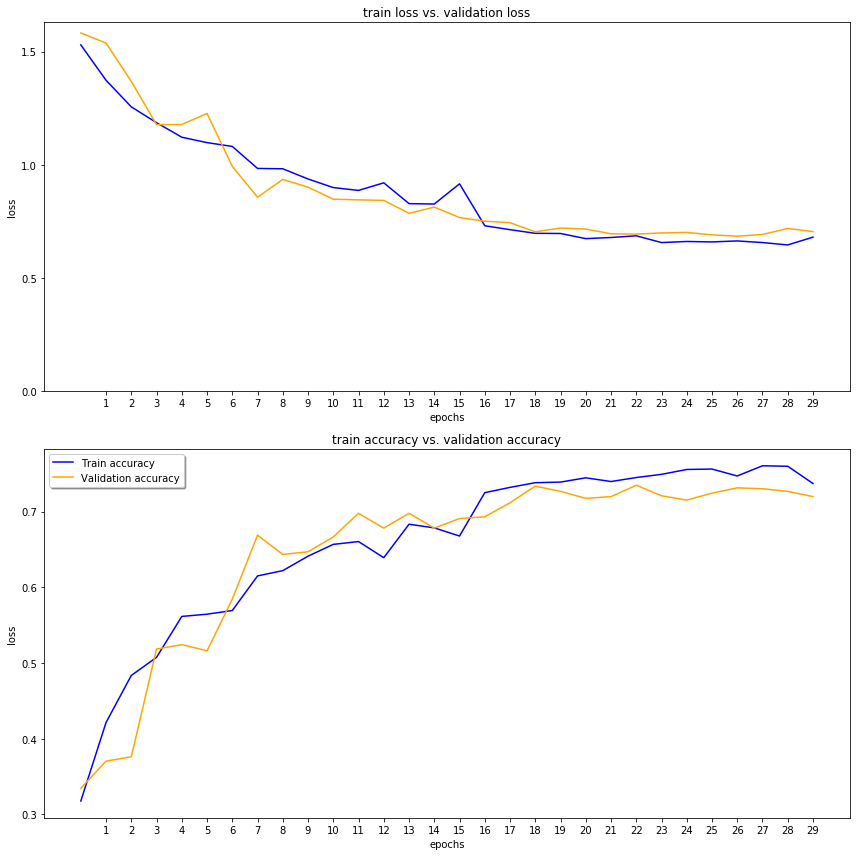

In [27]:
model.save_weights('/Users/flo/Desktop/456/_SEMESTER_PROJECT/saved_models/31.h5')
model.summary()

# evaluate model on test data
#scores = model.evaluate(X_test, y_test, verbose=2)
# verbose indiciator to display training progress info
# 1 (true) (default) | 0 (false)
print(NAME)

scores = model.evaluate(X_valid, y_valid, verbose=2)
print('Valid loss:', scores[0])
print('Valid accuracy:', scores[1])



scores = model.evaluate_generator(test_datagen, verbose=1)
print('Test Loss: ', scores[0])
print('Test Accuracy: ', scores[1])
# scores = model.evaluate(X_test, y_test, verbose=2)
# print('Test loss:', scores[0])
# print('Test accuracy:', scores[1])

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 12))
ax1.plot(hist.history['loss'], color='b', label="Train loss")
ax1.plot(hist.history['val_loss'], color='#ffa500', label="Validation loss")
ax1.set_xticks(np.arange(1, epochs, 1))
ax1.set_yticks(np.arange(0, 2, 0.5))
ax1.set_ylabel('loss')
ax1.set_title('train loss vs. validation loss')
ax1.set_xlabel('epochs')

ax2.plot(hist.history['accuracy'], color='b', label="Train accuracy")
ax2.plot(hist.history['val_accuracy'], color='#ffa500',label="Validation accuracy")
ax2.set_xticks(np.arange(1, epochs, 1))
ax2.set_ylabel('loss')
ax2.set_title('train accuracy vs. validation accuracy')
ax2.set_xlabel('epochs')

legend = plt.legend(loc='best', shadow=True)
plt.tight_layout()
plt.show()